<a href="https://colab.research.google.com/github/yingzibu/MOL2ADMET/blob/main/examples/experiments/ADMET_10_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet

! pip install dgllife --quiet
! pip install molvs --quiet
! pip install dgl -f https://data.dgl.ai/wheels/cu118/repo.html --quiet
! pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet

! pip install DeepPurpose --quiet
! pip install git+https://github.com/bp-kelley/descriptastorus --quiet
! pip install pandas-flavor --quiet

In [3]:
cd /content/drive/MyDrive/ADMET

/content/drive/MyDrive/ADMET


In [4]:
from os import walk
import os
files = next(walk('/content/drive/MyDrive/ADMET/'), (None, None, []))[2]
for file in files:
    if isinstance(file, str):
        file_type = file.split('.')[-1]
        # print(file_type)
        if file_type == 'bin' or file_type == 'pth':
            os.remove(file)

In [5]:
import matplotlib.pyplot as plt

def get_min(d:dict):
    min_key = next(iter(d))

    # Iterate over the keys in the dictionary
    for key in d:
        # If the value of the current key > the value of max_key, update max_key
        if d[key] < d[min_key]:
            min_key = key
    return min_key, d[min_key]

def plot_loss(train_dict, test_dict, name='test'):
    fig = plt.figure()
    plt.plot(list(train_dict.keys()), list(train_dict.values()), label='train')
    plt.plot(list(test_dict.keys()), list(test_dict.values()), label=name)
    argmin, min = get_min(test_dict)
    plt.plot(argmin, min, '*', label=f'min epoch {argmin}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('loss during training')
    plt.legend()
    plt.show()

In [6]:
from scripts.eval_utils import *
from scripts.preprocess_mols import *
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

device = 'cuda'
import sklearn.metrics as metrics

import numpy as np

def reg_evaluate(label_clean, preds_clean):
    mae = metrics.mean_absolute_error(label_clean, preds_clean)
    mse = metrics.mean_squared_error(label_clean, preds_clean)
    rmse = np.sqrt(mse) #mse**(0.5)
    r2 = metrics.r2_score(label_clean, preds_clean)

    print('MAE,      MSE,      RMSE,      R2')
    print("& %5.3f" % (mae), " &%5.3f" % (mse), " &%5.3f" % (rmse),
      " &%5.3f" % (r2))

    eval_result_r2 =   f'R2:     {r2:.3f}'
    eval_result_mae =  f'MAE:   {mae:.3f}'
    eval_result_rmse = f'RMSE: {rmse:.3f}'

    return eval_result_r2, eval_result_mae, eval_result_rmse

from mycolorpy import colorlist as mcp
import matplotlib.pyplot as plt

def eval_dict(y_probs:dict, y_label:dict, names:list, IS_R, draw_fig=False):
    if isinstance(IS_R, list): task_list = IS_R
    else: task_list = [IS_R] * len(names)
    for i, (name, IS_R) in enumerate(zip(names, task_list)):
        # IS_R = task_list[i]
        print('*'*15, name, '*'*15)
        # print('Regression task', IS_R)

        probs = y_probs[name]
        label = y_label[name]
        assert len(probs) == len(label)
        if IS_R == False: # classification task
            preds = get_preds(0.5, probs)
            evaluate(label, preds, probs)

        else: # regression task
            r2, mae, rmse = reg_evaluate(label, probs)
            if draw_fig:
                color = mcp.gen_color_normalized(cmap='viridis',
                                                data_arr=label)
                plt.scatter(label, probs, cmap='viridis', marker='.',
                            s=10, alpha=0.5, edgecolors='none', c=color)
                plt.xlabel(f'True {name}')
                plt.ylabel(f'Predicted {name}')
                plt.title(f'{name} prediction on test set')

                x0, xmax = plt.xlim()
                y0, ymax = plt.ylim()
                data_width = xmax - x0
                data_height = ymax - y0
                # print(x0, xmax, y0, ymax, data_width, data_height)
                plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8/0.95, r2)
                plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8,  mae)
                plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8*0.95, rmse)

                plt.show()
                plt.cla()
                plt.clf()
                plt.close()
        print()


MLP architecture

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self, **config):
        super(Classifier, self).__init__()
        dims = [config['in_dim'], config['hid_dims'], config['out_dim']]
        self.dims = dims
        neurons = [config['in_dim'], *config['hid_dims']]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) \
                         for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)
        self.final = nn.Linear(config['hid_dims'][-1], config['out_dim'])
        self.dropout = nn.Dropout(config['dropout'])

    def forward(self, x):
        for layer in self.hidden: x = F.relu(layer(x))
        x = self.dropout(x)
        x = self.final(x)
        return x

    def get_dim(self): return self.dims


AttentiveFP architecture

In [103]:
import time
import pandas as pd
import dgl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dgllife.model import model_zoo
from dgllife.utils import smiles_to_bigraph
from dgllife.utils import EarlyStopping, Meter
from dgllife.utils import AttentiveFPAtomFeaturizer
from dgllife.utils import AttentiveFPBondFeaturizer
from dgllife.data import MoleculeCSVDataset
from dgllife.model.gnn import AttentiveFPGNN
from dgllife.model.readout import AttentiveFPReadout

def get_model_AT_10_17(names, n_layers, graph_feat_size, num_timesteps, dropout):
    atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
    bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
    n_feats_num = atom_featurizer.feat_size('hv')
    e_feats_num = bond_featurizer.feat_size('he')

    model = model_zoo.AttentiveFPPredictor(
            node_feat_size=n_feats_num, edge_feat_size=e_feats_num,
            num_layers=n_layers, num_timesteps=num_timesteps,
            graph_feat_size=graph_feat_size,
            n_tasks=len(names), dropout=dropout)
    return model

def AttentiveFP(**config):
    return get_model_AT_10_17(config['prop_names'], config['n_layers'],
            config['graph_feat_size'], config['num_timesteps'], config['dropout'])

GIN architecture

In [78]:
# https://lifesci.dgl.ai/_modules/dgllife/model/pretrain.html

class GIN_MOD(nn.Module):
    """
    Reference: https://github.com/kexinhuang12345/DeepPurpose/blob/master/DeepPurpose/encoders.py#L392
    """
	## adapted from https://github.com/awslabs/dgl-lifesci/blob/2fbf5fd6aca92675b709b6f1c3bc3c6ad5434e96/examples/property_prediction/moleculenet/utils.py#L76
    def __init__(self, **config):
        super(GIN_MOD, self).__init__()
        self.gnn = load_pretrained('gin_supervised_contextpred')
        self.readout = AvgPooling()
        self.transform = nn.Linear(300, config['in_dim'])
        self.dropout = nn.Dropout(config['dropout'])
        self.hidden_dims = config['hid_dims']
        self.out_dim = config['out_dim']
        layer_size = len(self.hidden_dims)
        neurons = [config['in_dim'], *self.hidden_dims]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) \
                         for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)
        self.final = nn.Linear(self.hidden_dims[-1], self.out_dim)

    def forward(self, bg):
        # bg = bg.to(device)
        node_feats = [
            bg.ndata.pop('atomic_number'),
            bg.ndata.pop('chirality_type')
        ]
        edge_feats = [
            bg.edata.pop('bond_type'),
            bg.edata.pop('bond_direction_type')
        ]

        node_feats = self.gnn(bg, node_feats, edge_feats)
        x = self.readout(bg, node_feats)
        x = self.transform(x)
        for layer in self.hidden: x = F.leaky_relu(layer(x))
        x = self.final(x)
        return self.dropout(x)


## DATALOADER AND DATASET

In [14]:
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem.MACCSkeys import GenMACCSKeys
import torch.nn.functional as F

m = Chem.MolFromSmiles
header = ['bit' + str(i) for i in range(167)]

def smile_list_to_MACCS(smi_list:list):
    MACCS_list = []
    for smi in smi_list:
        maccs = [float(i) for i in list(GenMACCSKeys(m(smi)).ToBitString())]
        MACCS_list.append(maccs)
    return MACCS_list

import torch
def process(data):

    # data = convert_with_qed_sa(data)
    print('---> converting SMILES to MACCS...')
    MACCS_list = smile_list_to_MACCS(data['Drug'].tolist())
    data[header] = pd.DataFrame(MACCS_list)
    print('---> FINISHED')
    return data

MASK = -100

class nn_dataset(Dataset):
    def __init__(self, df, prop_names, mask=MASK):
        super(nn_dataset, self).__init__()
        df = process(df)
        df = df.fillna(mask)
        self.df = df
        self.len = len(df)
        self.fp = self.df[header]
        if isinstance(prop_names, str): prop_names = [prop_names]
        self.props = self.df[prop_names]

    def __getitem__(self, idx):
        fp = torch.tensor(self.fp.iloc[idx], dtype=torch.float32)
        label = torch.tensor(self.props.iloc[idx], dtype=torch.float32)
        return fp, label

    def __len__(self): return self.len

    def get_df(self): return self.df

In [82]:

def collate_molgraphs(data):
    assert len(data[0]) in [3, 4], \
        'Expect the tuple to be of length 3 or 4, got {:d}'.format(len(data[0]))
    if len(data[0]) == 3:
        smiles, graphs, labels = map(list, zip(*data))
        masks = None
    else:
        smiles, graphs, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)

    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)
        # masks = (labels == MASK).long()
    return smiles, bg, labels, masks

def get_AttentiveFP_dataset(df, name):
    atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
    bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
    time_string = time.strftime("%m_%d_%Y_%H:%M:%S", time.localtime())

    params = {'smiles_to_graph': smiles_to_bigraph,
            'node_featurizer': atom_featurizer,
            'edge_featurizer': bond_featurizer,
            'smiles_column': 'Drug',
            'cache_file_path': time_string+'.bin',
            'task_names': name, 'load': True, 'n_jobs': len(name)*2}
    graph_dataset = MoleculeCSVDataset(df, **params)
    return graph_dataset

def get_AttentiveFP_loader(df, name, **loader_params):
    dataset = get_AttentiveFP_dataset(df, name)
    loader_params['collate_fn'] = collate_molgraphs
    loader = DataLoader(dataset, **loader_params)
    return loader

In [83]:
from dgllife.model import load_pretrained
from dgl.nn.pytorch.glob import AvgPooling
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from functools import partial
import torch
from dgllife.utils import smiles_to_bigraph, PretrainAtomFeaturizer, PretrainBondFeaturizer

MASK = -100

class GIN_dataset(Dataset):
    def __init__(self, df, names, mask=MASK):
        df = df.fillna(mask)
        self.names = names
        self.df = df
        self.len = len(df)
        self.props = self.df[names]
        self.node_featurizer = PretrainAtomFeaturizer()
        self.edge_featurizer = PretrainBondFeaturizer()
        self.fc = partial(smiles_to_bigraph, add_self_loop=True)
    def __len__(self): return self.len
    def __getitem__(self, idx):
        v_d = self.df.iloc[idx]['Drug']
        v_d = self.fc(smiles=v_d, node_featurizer = self.node_featurizer,
                      edge_featurizer = self.edge_featurizer)
        label = torch.tensor(self.props.iloc[idx], dtype=torch.float32)
        return v_d, label

import dgl
def get_GIN_dataloader(datasets, **loader_params):
    def dgl_collate_func(data):
        x, labels = map(list, zip(*data))
        bg = dgl.batch(x)
        labels = torch.stack(labels, dim=0)
        bg.set_n_initializer(dgl.init.zero_initializer)
        bg.set_e_initializer(dgl.init.zero_initializer)
        return bg, labels
    loader_params['collate_fn'] = dgl_collate_func
    return DataLoader(datasets, **loader_params)

# MODEL initialization, train epoch function

In [104]:
def init_model(**config):
    """need incorporate all models here! """
    if config['model_type'] == 'MLP':
        model = Classifier(**config)
    elif config['model_type'] == 'GIN':
        model = GIN_MOD(**config) # need work config GIN out_dim
    elif config['model_type'] == 'AttentiveFP':
        model = AttentiveFP(**config)
    elif config['model_type'] == 'RNN': pass
    return model

def get_loss_fn(IS_R):
    if IS_R: return nn.MSELoss(reduction='sum')
    else: return nn.BCEWithLogitsLoss(reduction='sum')

def get_train_fn(model_type):
    if model_type == 'MLP': return train_epoch_MLP

    elif model_type == 'GIN': return train_epoch_MLP
    elif model_type == 'AttentiveFP': return train_epoch_MLP
    elif model_type == 'RNN': pass

def get_eval_fn(model_type):
    if model_type == 'MLP': return train_epoch_MLP

    elif model_type == 'GIN': return train_epoch_MLP
    elif model_type == 'AttentiveFP': return train_epoch_MLP
    elif model_type == 'RNN': pass


def get_loader(df, names, params, model_type):
    print('--> preparing data loader for model type ', model_type)
    if model_type == 'MLP': return DataLoader(nn_dataset(df, names), **params)

    elif model_type == 'GIN':
        return get_GIN_dataloader(GIN_dataset(df, names), **params)

    elif model_type == 'AttentiveFP':
        return get_AttentiveFP_loader(df, names, **params)

    elif model_type == 'RNN': pass


def train_epoch_MLP(model, loader, IS_R, names, device, epoch=None,
                    optimizer=None, MASK=-100, scale_dict=None):
    if optimizer==None: # no optimizer, either validation or test
        model.eval()    # model evaluation for either valid or test
        if epoch != None: train_type='Valid' # if epoch is inputted, its valid
        else: train_type = 'Test' # if no epoch information, its test
    else: model.train(); train_type='Train' # if optimizer inputted, its train

    if isinstance(IS_R, list): IS_R_list = IS_R
    else: IS_R_list = [IS_R] * len(names)
    losses = 0
    y_probs = {}
    y_label = {}
    for idx, batch_data in enumerate(loader):
        """
        len(batch_data) could determine which algorithm
        len(batch_data) == 2: MLP, GIN
        len(batch_data) == 4: AttentiveFP
        """
        if len(batch_data) == 2:  # MLP or GIN
            fp, labels = batch_data
            fp, labels = fp.to(device), labels.to(device)
            mask = labels == MASK
            pred = model(fp)
        elif len(batch_data) == 4: # attentiveFP
            smiles, bg, labels, masks = batch_data
            bg, labels, masks = bg.to(device), labels.to(device), masks.to(device)
            n_feats = bg.ndata.pop('hv').to(device)
            e_feats = bg.edata.pop('he').to(device)
            pred = model(bg, n_feats, e_feats)
            mask = masks < 1

        for j, (name, IS_R) in enumerate(zip(names, IS_R_list)):
            loss_func = get_loss_fn(IS_R)
            probs = pred[:, j][~mask[:, j]]
            label = labels[:, j][~mask[:, j]]
            if j == 0: loss  = loss_func(probs, label)
            else:      loss += loss_func(probs, label)
            if IS_R == False: probs = F.sigmoid(probs)

            if train_type != 'Train': # validation
                probs = probs.cpu().detach().numpy().tolist()
                label = label.cpu().detach().numpy().tolist()
                if scale_dict != None:
                    min_here = scale_dict[name][0]
                    max_here = scale_dict[name][1]
                    del_here = max_here - min_here
                    label = [l * del_here + min_here for l in label]
                    probs = [p * del_here + min_here for p in probs]

                if idx ==0: y_probs[name], y_label[name] = probs, label
                else:
                    y_probs[name] += probs
                    y_label[name] += label

        losses += loss.item()
        if optimizer != None: optimizer.zero_grad(); loss.backward(); optimizer.step()

    total_loss = losses / len(loader.dataset)
    if epoch != None: # train or valid
        print(f'Epoch:{epoch}, [{train_type}] Loss: {total_loss:.3f}')
    else: # test
        print(f'[{train_type}] Loss: {total_loss:.3f}')
        eval_dict(y_probs, y_label, names, IS_R_list, draw_fig=True)

    if train_type == 'Train': return total_loss
    else: return total_loss, y_probs, y_label


In [105]:
from dgllife.utils import EarlyStopping, Meter
from tqdm import tqdm

class PRED:
    def __init__(self, **config):
        cuda = torch.cuda.is_available()
        if cuda: self.device = 'cuda'
        else:    self.device = 'cpu'
        self.prop_names = config['prop_names']
        self.config = config
        if 'scale_dict' not in config: self.scale_dict = None
        else: self.scale_dict = config['scale_dict']
        self.model_type = config['model_type']
        print('model type: ', self.model_type)
        self.model_path = config['model_path']

        self.eval_fn = get_eval_fn(self.model_type)
        self.train_fn = get_train_fn(self.model_type)

        self.model = init_model(**config).to(self.device)

        self.IS_R = config['IS_R'] # could be list, could be true/false
        self.optimizer = torch.optim.AdamW(self.model.parameters(),
                        lr=config['lr'], weight_decay=config['wd'])
        self.stopper = EarlyStopping(mode='lower', patience=config['patience'])

        self.min_loss = np.inf
        self.best_epoch = 0
        self.train_dict = {}
        self.valid_dict = {}

    def load_model(self, path):
        con = self.config.copy()
        con['dropout'] = 0
        self.model = init_model(**con).to(self.device)
        print('load pretrained model from ', path)
        self.model.load_state_dict(torch.load(path, map_location=self.device))

    def eval(self, loader, path=None, ver=False):

        print('#'*68)
        print('#'*30, 'CONFIG', '#'*30)
        print('#'*68)
        for i, j in self.config.items():
            print(i, ':', j)
        print('#'*68)

        if path != None: self.load_model(path)
        if ver:
            print(f"best epoch: {self.best_epoch}, min loss: {self.min_loss:.4f}")
            plot_loss(self.train_dict, self.valid_dict, name='valid')
        self.eval_fn(self.model, loader, self.IS_R, self.prop_names, self.device,
               epoch=None, optimizer=None, MASK=-100, scale_dict=self.scale_dict)

    def train(self, data_loader, val_loader, test_loader=None):
        if self.best_epoch != 0: self.load_model(self.model_path)
        # train_dict, valid_dict = {}, {}
        for epoch in range(500):
            score = self.train_fn(self.model, data_loader, self.IS_R,
                                  self.prop_names, self.device, epoch,
                                  self.optimizer, scale_dict=self.scale_dict)
            val_score, probs, labels = self.train_fn(self.model, val_loader,
                                       self.IS_R, self.prop_names, self.device,
                                       epoch, scale_dict=self.scale_dict)
            self.train_dict[epoch] = score
            self.valid_dict[epoch] = val_score
            early_stop = self.stopper.step(val_score, self.model)
            if val_score < self.min_loss:
                print(f'prev min loss {self.min_loss:.3f}, '
                      f'now loss {val_score:.3f} |',
                      f'save model at epoch: {epoch}')
                self.min_loss = val_score
                torch.save(self.model.state_dict(), self.model_path)
                self.best_epoch = epoch
                eval_dict(probs, labels, self.prop_names, IS_R=self.IS_R)

            if early_stop: print('early stop'); break
            # print(train_dict)
            if epoch % 10 == 0 and epoch != 0:
                plot_loss(self.train_dict, self.valid_dict, name='valid')

        print(f"best epoch: {self.best_epoch}, min loss: {self.min_loss:.4f}")
        plot_loss(self.train_dict, self.valid_dict, name='valid')

        if test_loader != None: self.eval(test_loader, self.model_path, True)


In [86]:
from scripts.preprocess_mols import preprocess, rename_cols, clean_mol, scal
from tdc.single_pred import ADME
from tdc.single_pred import Tox
from tdc.utils import retrieve_label_name_list
label_list = retrieve_label_name_list('herg_central')

def collect_data_10_17(names:list, clean_mol_=False):
    for i, name in enumerate(names):
        print('*'*15, name, '*'*15)
        if name in label_list:
            data = Tox(name='herg_central', label_name=name)
        else:
            try: data = ADME(name=name)
            except:
                try: data = Tox(name=name)
                except: print('cannot read data!'); break
            # data.label_distribution()
        split = data.get_split()
        train, valid, test = split['train'], split['valid'], split['test']
        if clean_mol_:
            train, valid, test = clean_mol(train), clean_mol(valid), clean_mol(test)

        train = rename_cols(train[['Drug', 'Y']], name)
        valid = rename_cols(valid[['Drug', 'Y']], name)
        test  = rename_cols(test[['Drug', 'Y']],  name)

        if i == 0: trains, valids, tests = train, valid, test
        else:
            trains = trains.merge(train, how='outer')
            valids = valids.merge(valid, how='outer')
            tests = tests.merge(test, how='outer')

    return trains, valids, tests


In [102]:

import pandas as pd
def count_(df:pd.DataFrame):
    for col in df.columns:
        if col != 'Drug':
            try:
                ones = df[col].value_counts()[1]
                zero = df[col].value_counts()[0]
            except: ones = 'Nan'; zero = 'Nan'
            print(col, f'\t 0: {zero} | 1: {ones}')
    print()

def scale(trains, valids, tests):
    print('scaling train valid test data set for regression task ')
    dict_scale = {}
    for col in trains.columns:
        if col == 'Drug': pass
        else:
            # print(col)
            min_here = min(trains[col].min(), valids[col].min(), tests[col].min())
            max_here = max(trains[col].max(), valids[col].max(), tests[col].max())
            dict_scale[col] = [min_here, max_here]
            delta_here = max_here - min_here
            trains[col] = (trains[col] - min_here) / delta_here
            valids[col] = (valids[col] - min_here) / delta_here
            tests[col]  = (tests[col]  - min_here) / delta_here

    return trains, valids, tests, dict_scale


def get_multi_loader(trains, valids, tests, prop_names, batch_size, model_type):
    print('---> loader for', prop_names)
    loader_params = {'batch_size': batch_size, 'shuffle': True,
                     'drop_last': False, 'num_workers': 0}
    train_loader = get_loader(trains, prop_names, loader_params, model_type)
    valid_loader = get_loader(valids, prop_names, loader_params, model_type)
    test_params = {'batch_size': batch_size, 'shuffle': False,
                   'drop_last': False, 'num_workers': 0}
    test_loader = get_loader(tests, prop_names, test_params, model_type)
    return train_loader, valid_loader, test_loader

# trains, valids, tests, dict_scale = scale(trains, valids, tests)

# batch_size = 64
# loader_params = {'batch_size': batch_size, 'shuffle': True}
# train_loader = get_loader(trains, names, loader_params, 'MLP')
# valid_loader = get_loader(valids, names, loader_params, 'MLP')

# test_params = {'batch_size': batch_size, 'shuffle': False}
# test_loader  = get_loader(tests,  names,  test_params,  'MLP')


In [97]:
names_dict = {}
names_reg = ['Caco2_Wang', 'Lipophilicity_AstraZeneca',
         'HydrationFreeEnergy_FreeSolv', 'Solubility_AqSolDB', 'LD50_Zhu'] # regression task
names_cls = ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith',
             'CYP1A2_Veith', 'CYP2C9_Veith'] + \
            ['BBB_Martins', 'Bioavailability_Ma',
             'Pgp_Broccatelli', 'HIA_Hou','PAMPA_NCATS'] + \
            ['hERG_Karim', 'AMES']

for name in names_reg + names_cls:
    if name in names_reg:   names_dict[name] = True  # regression task
    elif name in names_cls: names_dict[name] = False # classification task

names_dict

{'Caco2_Wang': True,
 'Lipophilicity_AstraZeneca': True,
 'HydrationFreeEnergy_FreeSolv': True,
 'Solubility_AqSolDB': True,
 'LD50_Zhu': True,
 'CYP2C19_Veith': False,
 'CYP2D6_Veith': False,
 'CYP3A4_Veith': False,
 'CYP1A2_Veith': False,
 'CYP2C9_Veith': False,
 'BBB_Martins': False,
 'Bioavailability_Ma': False,
 'Pgp_Broccatelli': False,
 'HIA_Hou': False,
 'PAMPA_NCATS': False,
 'hERG_Karim': False,
 'AMES': False}

In [ ]:
names = ['Caco2_Wang', 'Lipophilicity_AstraZeneca',
         'HydrationFreeEnergy_FreeSolv', 'Solubility_AqSolDB', 'LD50_Zhu']

model_type = 'AttentiveFP' # 'MLP' 'GIN'

IS_R = [names_dict[name] for name in names]
trains, valids, tests = collect_data_10_17(names)

in_dim = 256
hid_dims = [128, 64]
dropout = 0.1
lr = 1e-4
wd = 1e-5
patience = 10 # stop if loss no decrease after epochs # patience
batch_size = 32

# special for AttentiveFP
graph_feat_size = 300
n_layers = 5
num_timesteps = 2 # times of updating the graph representations with GRU



def get_config(model_type, names):

    config_MLP = {'model_type': 'MLP',
            'in_dim': 167,
            'hid_dims': hid_dims,
            'out_dim': len(names),
            'prop_names': names,
            'dropout': dropout,
            'IS_R': IS_R,
            'batch_size': batch_size,
            'lr': lr,
            'wd': wd,
            'patience': patience,
            'model_path': f'ckpt_MLP.pt',
            'scale_dict': None}

    config_ATF = {'model_type': 'AttentiveFP',
            'graph_feat_size': graph_feat_size,
            'num_timesteps': num_timesteps,
            'n_layers': n_layers,
            'out_dim': len(names),
            'prop_names': names,
            'dropout': dropout,
            'IS_R': IS_R,
            'batch_size': batch_size,
            'lr': lr,
            'wd': wd,
            'patience': patience,
            'model_path': 'ckpt_AT.pt',
            'scale_dict': None}

    config_GIN = {'model_type': 'GIN',
            'in_dim': in_dim,
            'hid_dims': hid_dims,
            'out_dim': len(names),
            'prop_names': names,
            'dropout': dropout,
            'batch_size': batch_size,
            'IS_R': IS_R,
            'lr': lr,
            'wd': wd,
            'patience': patience,
            'model_path': 'ckpt_GIN.pt',
            'scale_dict': None}

    if model_type == 'MLP':           con_MO = config_MLP
    elif model_type == 'AttentiveFP': con_MO = config_ATF
    elif model_type == 'GIN':         con_MO = config_GIN
    elif model_type == 'RNN':         pass
    else: print('Error !{MLP, AttentiveFP, GIN, RNN}'); return None
    return con_MO


"""
Multiple task
"""
con_MO = get_config(model_type, names)

train_loader_MO, valid_loader_MO, test_loader_MO = get_multi_loader(
                        trains, valids, tests, con_MO['prop_names'],
                        con_MO['batch_size'], con_MO['model_type'])

models_MO = PRED(**con_MO)
models_MO.train(train_loader_MO, valid_loader_MO, test_loader_MO)


"""
Single task
"""

models_all = []
test_loaders = []
configs = []

# in_dim = 167
# hid_dims = [128, 64, 32, 16]
# dropout = 0.2
# lr = 1e-4
# wd = 1e-5
# patience = 10
# batch_size = 32

for i, name in enumerate(names):
    print(i, name)
    IS_R = [names_dict[name]]

    model_path = f'ckpt_{model_type}_{i}.pt'
    config = con_MO.copy()
    config['prop_names'] = [name]
    config['out_dim'] = 1
    config['IS_R'] = IS_R
    config['model_path'] = model_path

    # config = {'model_type': 'MLP',
    #       'in_dim': in_dim,
    #       'hid_dims': hid_dims,
    #       'out_dim': len([name]),
    #       'prop_names': [name],
    #       'dropout': dropout,
    #       'IS_R': True,
    #       'batch_size': batch_size,
    #       'lr': lr,
    #       'wd': wd,
    #       'patience': patience,
    #       'model_path': model_path,
    #       'scale_dict': None}

    train_loader, valid_loader, test_loader = get_multi_loader(
                        trains, valids, tests, config['prop_names'],
                        config['batch_size'], config['model_type'])
    test_loaders.append(test_loader)
    models = PRED(**config)
    configs.append(config)
    models.train(train_loader, valid_loader, test_loader)
    models_all.append(models)


## Results, multi and single:


In [ ]:
print('multi task for ', names)
models_MO.eval(test_loader_MO, con_MO['model_path'], True)
print()
print()
print('---> Then single task results: ')
for i, name in enumerate(names):
    print('#'*80)
    print(name)
    print('#'*80)
    models = models_all[i]
    test_loader = test_loaders[i]
    config = configs[i]
    models.eval(test_loader, config['model_path'], True)

In [ ]:
# models_all = []
# test_loaders = []
# configs = []

# # in_dim = 167
# # hid_dims = [128, 64, 32, 16]
# # dropout = 0.2
# # lr = 1e-4
# # wd = 1e-5
# # patience = 10
# # batch_size = 32

# for i, name in enumerate(names):
#     print(i, name)
#     IS_R = [names_dict[name]]

#     model_path = f'ckpt_{model_type}_{i}.pt'
#     config = con_MO.copy()
#     config['prop_names'] = [name]
#     config['out_dim'] = 1
#     config['IS_R'] = IS_R
#     config['model_path'] = model_path

#     # config = {'model_type': 'MLP',
#     #       'in_dim': in_dim,
#     #       'hid_dims': hid_dims,
#     #       'out_dim': len([name]),
#     #       'prop_names': [name],
#     #       'dropout': dropout,
#     #       'IS_R': True,
#     #       'batch_size': batch_size,
#     #       'lr': lr,
#     #       'wd': wd,
#     #       'patience': patience,
#     #       'model_path': model_path,
#     #       'scale_dict': None}

#     train_loader, valid_loader, test_loader = get_multi_loader(
#                         trains, valids, tests, config['prop_names'],
#                         config['batch_size'], config['model_type'])
#     test_loaders.append(test_loader)
#     models = PRED(**config)
#     configs.append(config)
#     models.train(train_loader, valid_loader, test_loader)
#     models_all.append(models)

################################################################################
Caco2_Wang
################################################################################
load pretrained model from  ckpt_0.pt
####################################################################
############################## CONFIG ##############################
####################################################################
model_type : MLP
in_dim : 167
hid_dims : [128, 64, 32, 16]
out_dim : 1
prop_names : ['Caco2_Wang']
dropout : 0.2
IS_R : True
batch_size : 32
lr : 0.0001
wd : 1e-05
patience : 10
model_path : ckpt_0.pt
scale_dict : None
####################################################################
best epoch: 43, min loss: 0.0087


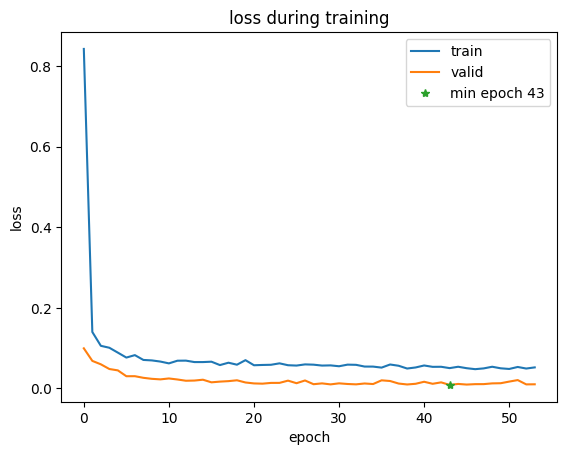

[Test] Loss: 0.012
*************** Caco2_Wang ***************
MAE,      MSE,      RMSE,      R2
& 0.412  &0.296  &0.544  &0.533


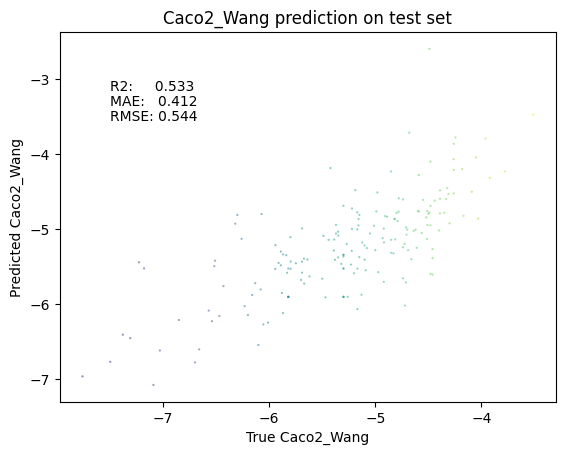


################################################################################
Lipophilicity_AstraZeneca
################################################################################
load pretrained model from  ckpt_1.pt
####################################################################
############################## CONFIG ##############################
####################################################################
model_type : MLP
in_dim : 167
hid_dims : [128, 64, 32, 16]
out_dim : 1
prop_names : ['Lipophilicity_AstraZeneca']
dropout : 0.2
IS_R : True
batch_size : 32
lr : 0.0001
wd : 1e-05
patience : 10
model_path : ckpt_1.pt
scale_dict : None
####################################################################
best epoch: 36, min loss: 0.1356


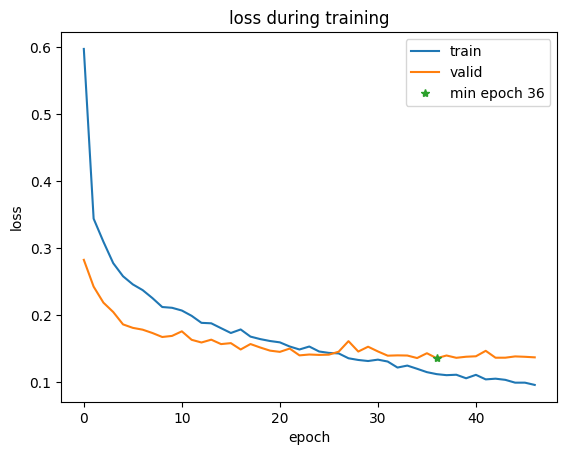

[Test] Loss: 0.136
*************** Lipophilicity_AstraZeneca ***************
MAE,      MSE,      RMSE,      R2
& 0.646  &0.726  &0.852  &0.509


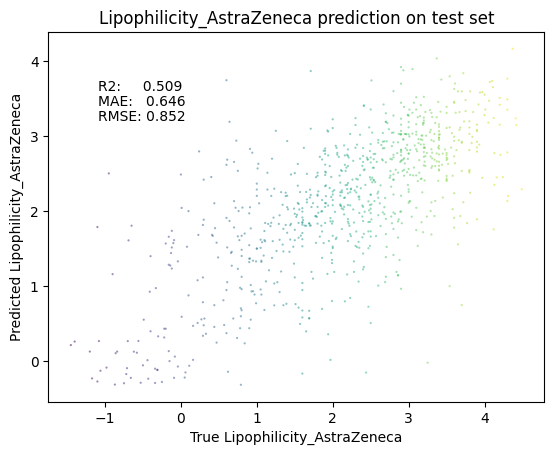


################################################################################
HydrationFreeEnergy_FreeSolv
################################################################################
load pretrained model from  ckpt_2.pt
####################################################################
############################## CONFIG ##############################
####################################################################
model_type : MLP
in_dim : 167
hid_dims : [128, 64, 32, 16]
out_dim : 1
prop_names : ['HydrationFreeEnergy_FreeSolv']
dropout : 0.2
IS_R : True
batch_size : 32
lr : 0.0001
wd : 1e-05
patience : 10
model_path : ckpt_2.pt
scale_dict : None
####################################################################
best epoch: 23, min loss: 0.0466


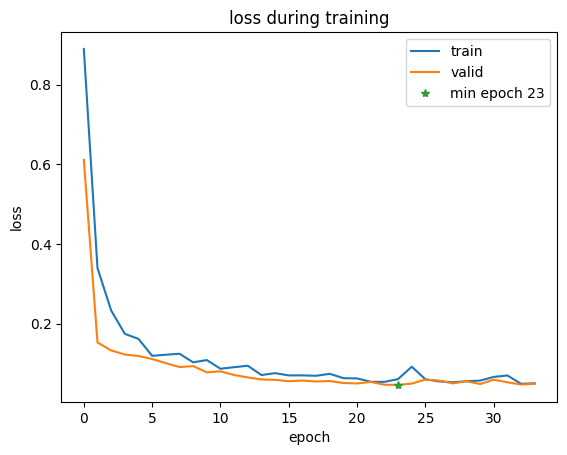

[Test] Loss: 0.050
*************** HydrationFreeEnergy_FreeSolv ***************
MAE,      MSE,      RMSE,      R2
& 0.841  &1.771  &1.331  &0.892


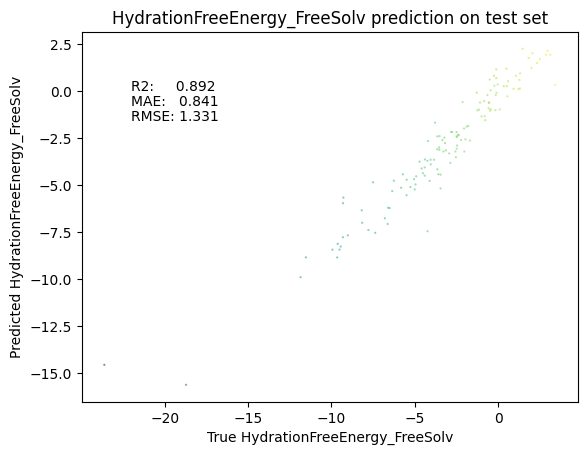


################################################################################
Solubility_AqSolDB
################################################################################
load pretrained model from  ckpt_3.pt
####################################################################
############################## CONFIG ##############################
####################################################################
model_type : MLP
in_dim : 167
hid_dims : [128, 64, 32, 16]
out_dim : 1
prop_names : ['Solubility_AqSolDB']
dropout : 0.2
IS_R : True
batch_size : 32
lr : 0.0001
wd : 1e-05
patience : 10
model_path : ckpt_3.pt
scale_dict : None
####################################################################
best epoch: 46, min loss: 0.6983


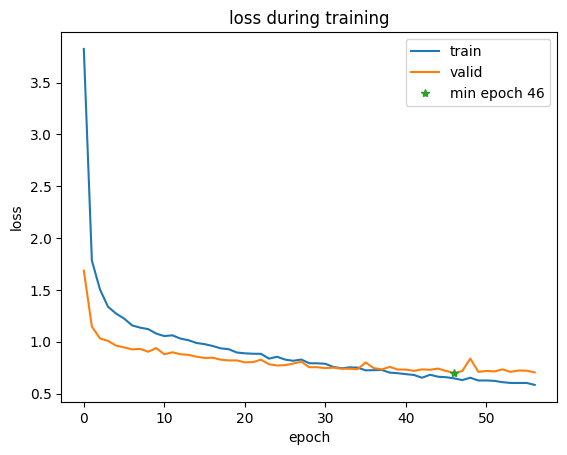

[Test] Loss: 0.695
*************** Solubility_AqSolDB ***************
MAE,      MSE,      RMSE,      R2
& 0.916  &1.566  &1.251  &0.712


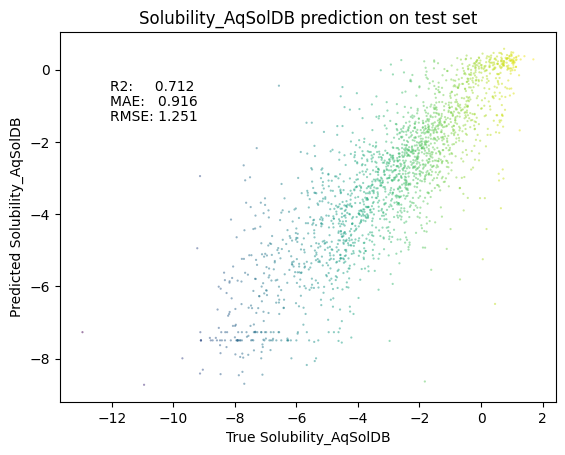


################################################################################
LD50_Zhu
################################################################################
load pretrained model from  ckpt_4.pt
####################################################################
############################## CONFIG ##############################
####################################################################
model_type : MLP
in_dim : 167
hid_dims : [128, 64, 32, 16]
out_dim : 1
prop_names : ['LD50_Zhu']
dropout : 0.2
IS_R : True
batch_size : 32
lr : 0.0001
wd : 1e-05
patience : 10
model_path : ckpt_4.pt
scale_dict : None
####################################################################
best epoch: 34, min loss: 0.1396


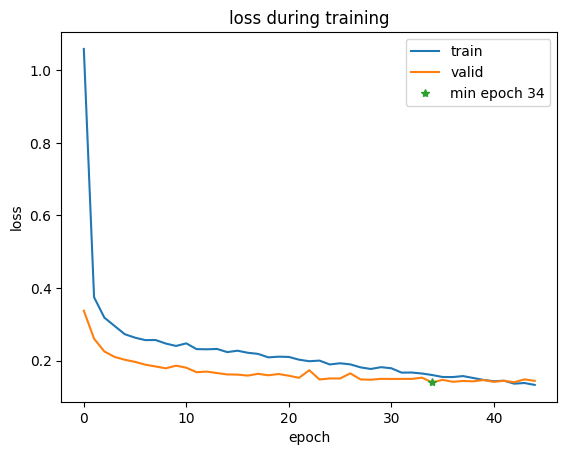

[Test] Loss: 0.125
*************** LD50_Zhu ***************
MAE,      MSE,      RMSE,      R2
& 0.465  &0.381  &0.617  &0.574


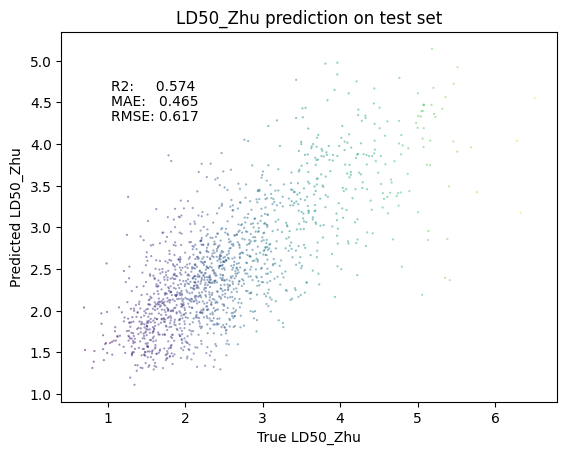

In [73]:
# for i, name in enumerate(names):
#     print('#'*80)
#     print(name)
#     print('#'*80)
#     models = models_all[i]
#     test_loader = test_loaders[i]
#     config = configs[i]
#     models.eval(test_loader, config['model_path'], True)